In [2]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import warnings





warnings.filterwarnings("ignore")

PATH = Path("emotions.csv") 
df = pd.read_csv(PATH)

print(df.shape)
df.head(3)


(2132, 2549)


,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.07,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.0,-162.0,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.55,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.6,-31.6,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.90,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.0,-148.0,281.00,POSITIVE


In [3]:
# Nettoyage léger : nom de colonnes propre
df.columns = [c.strip().replace(' ', '_').replace('#','id') for c in df.columns]

# Label en catégories & comptage
df['label'] = df['label'].astype('category')
print(df['label'].value_counts())

# Aperçu des familles de features
cols = df.columns.tolist()
families = {
    'means_a' : [c for c in cols if c.startswith('mean_') and c.endswith('_a')],
    'means_b' : [c for c in cols if c.startswith('mean_') and c.endswith('_b')],
    'stds_a'  : [c for c in cols if c.startswith('std_') and c.endswith('_a')],
    'stds_b'  : [c for c in cols if c.startswith('std_') and c.endswith('_b')],
    'fft_a'   : [c for c in cols if c.startswith('fft_') and c.endswith('_a')],
    'fft_b'   : [c for c in cols if c.startswith('fft_') and c.endswith('_b')],
}
{k: len(v) for k,v in families.items()}


label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64


{'means_a': 54,
 'means_b': 55,
 'stds_a': 0,
 'stds_b': 0,
 'fft_a': 750,
 'fft_b': 750}

Vérifie l’équilibre des classes.

Comprends la structure : ce dataset fournit beaucoup de features statistiques (mean_*, std_*) et des coeffs FFT (fft_*). Les suffixes _a / _b semblent être deux groupes (peut-être 2 hémisphères / 2 capteurs). On traitera ça comme deux “vues” de capteurs.

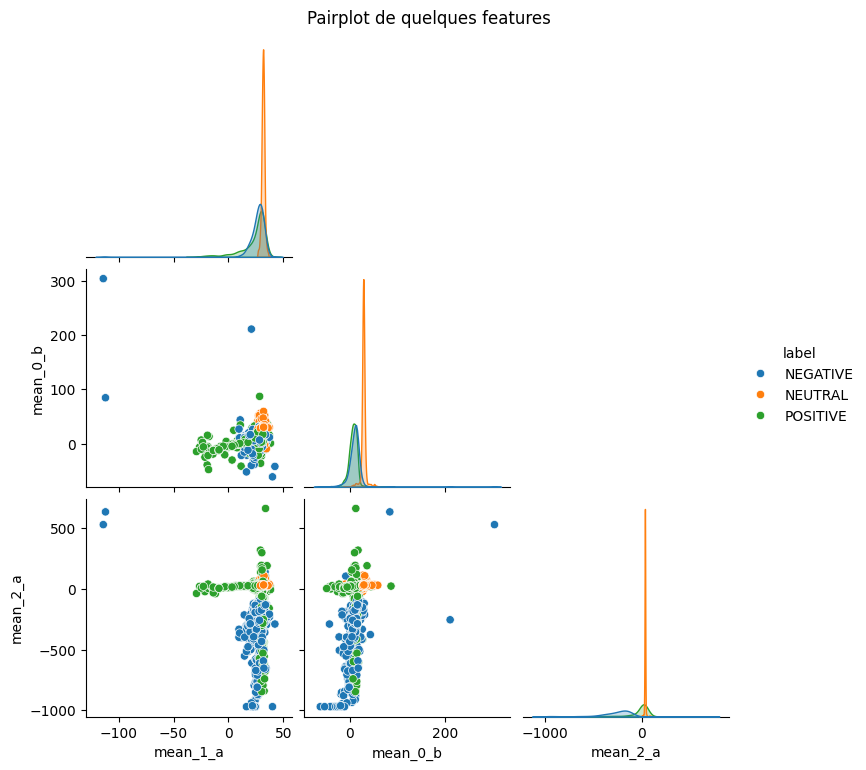

In [ ]:

small_cols = [families['means_a'][0], families['means_b'][0],
              families['stds_a'][0] if families['stds_a'] else families['means_a'][1]]
sns.pairplot(df[small_cols + ['label']], hue='label', corner=True, diag_kind='kde')
plt.suptitle("Pairplot de quelques features", y=1.02); plt.show()

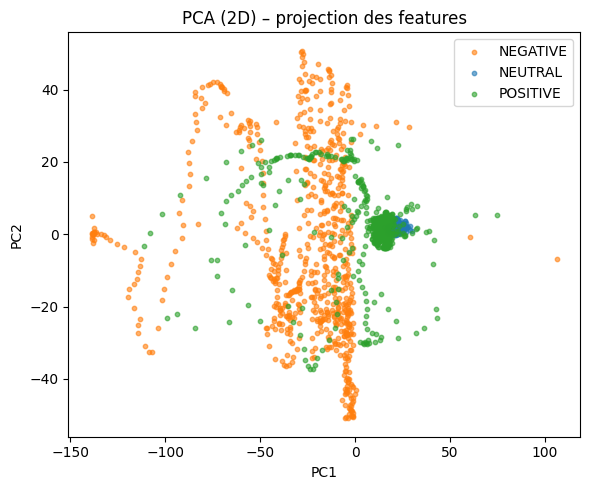

Explained variance: [0.36772564 0.09553894]


In [ ]:
# PCA 2D 

feat_cols = [c for c in df.columns if c!='label']
X = df[feat_cols].values
y = df['label'].cat.codes.values

Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=0)
Xp = pca.fit_transform(Xz)

plt.figure(figsize=(6,5))
for lab, col in zip(df['label'].cat.categories, ['tab:orange','tab:blue','tab:green']):
    idx = df['label']==lab
    plt.scatter(Xp[idx,0], Xp[idx,1], s=10, alpha=0.6, label=lab, c=col)
plt.legend(); plt.title("PCA (2D) – projection des features"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

print("Explained variance:", pca.explained_variance_ratio_)




Pairplot : repère séparations grossières.

PCA : voit si une structure globale sépare un peu les classes. Si oui ->bon signe.

In [6]:
# Features/label
X = df.drop(columns=['label']).values
y = df['label'].cat.codes.values  # 0..2

# Split CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Deux baselines simples
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=None))
])

pipe_lda = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearDiscriminantAnalysis())
])

for name, pipe in [('LogReg', pipe_logreg), ('LDA', pipe_lda)]:
    acc = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy')
    f1m = cross_val_score(pipe, X, y, cv=cv, scoring='f1_macro')
    print(f"{name} | Acc={acc.mean():.3f} ± {acc.std():.3f} | F1_macro={f1m.mean():.3f} ± {f1m.std():.3f}")


LogReg | Acc=0.965 ± 0.013 | F1_macro=0.965 ± 0.013
LDA | Acc=0.771 ± 0.009 | F1_macro=0.770 ± 0.010


Standardiser (z-score) est crucial avec un mix de stats/FFT.

CV stratifiée 5-fold : mesure robuste (évite split chanceux).

Métriques : Accuracy + F1 macro (équilibre les classes).

Limitation : le dataset n’indique pas clairement les sujets. Avec seulement 2 personnes enregistrées, une vraie LOSO serait préférable, mais impossible sans colonnes subject. 

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.70      0.75       142
     NEUTRAL       0.84      0.90      0.87       143
    POSITIVE       0.72      0.75      0.74       142

    accuracy                           0.79       427
   macro avg       0.79      0.79      0.79       427
weighted avg       0.79      0.79      0.79       427



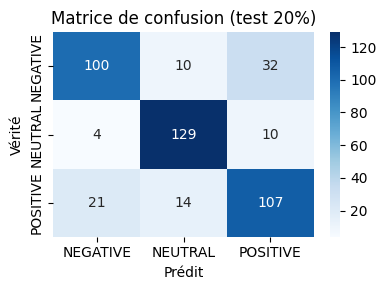

In [7]:

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

best = pipe_lda.fit(Xtr, ytr)  # LDA souvent très bon sur features “parsimonieux”
yp = best.predict(Xte)

print(classification_report(yte, yp, target_names=df['label'].cat.categories))
cm = confusion_matrix(yte, yp)


plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df['label'].cat.categories,
            yticklabels=df['label'].cat.categories)
plt.xlabel("Prédit"); plt.ylabel("Vérité"); plt.title("Matrice de confusion (test 20%)")
plt.tight_layout(); plt.show()


In [8]:

result = permutation_importance(best, StandardScaler().fit_transform(Xtr), ytr,
                                n_repeats=10, random_state=0, scoring='f1_macro')

importances = pd.Series(result.importances_mean, index=df.drop(columns=['label']).columns)
top20 = importances.sort_values(ascending=False).head(20)
top20


mean_3_b       0.154018
mean_d_10_b    0.070018
mean_0_b       0.057054
mean_d_15_a    0.050935
min_q_5_b      0.049112
min_q_5_a      0.030720
min_q_11_a     0.024417
mean_d_1_a2    0.022311
mean_d_13_b    0.022258
max_q_3_a      0.021176
min_q_19_a     0.019855
max_q_13_b     0.017430
max_q_11_b     0.016767
mean_d_6_a     0.015829
mean_d_6_b     0.014585
min_q_19_b     0.014507
mean_d_5_b     0.014061
min_q_8_a      0.013737
mean_d_36_a    0.012282
min_q_13_a     0.010935
dtype: float64

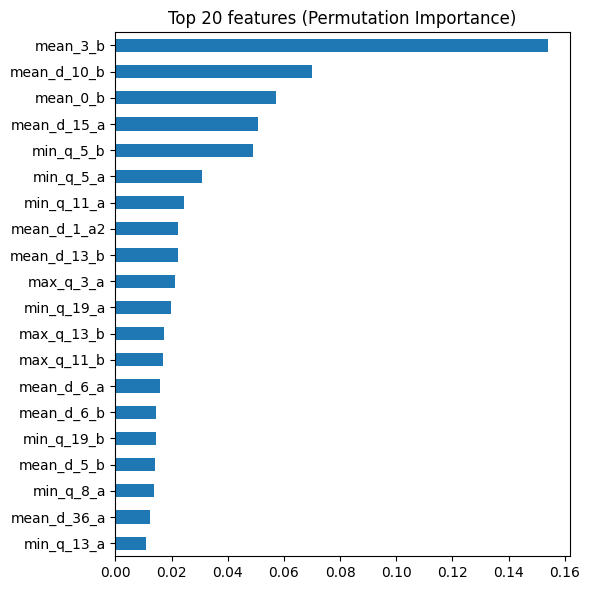

In [12]:
plt.figure(figsize=(6,6))
top20.sort_values().plot(kind='barh')
plt.title("Top 20 features (Permutation Importance)")
plt.tight_layout(); plt.show()


permutation dit quelles familles portent le signal (ex: means_* vs fft_*).


In [10]:
agg = (importances
       .groupby(importances.index.map(lambda c: c.split('_')[-1]))  # dernier token: a/b
       .mean()
       .sort_values(ascending=False))
agg


b     0.000546
a     0.000007
a2   -0.000593
b2   -0.014505
dtype: float64

LDA apprend une projection linéaire qui sépare au mieux les classes. Sa sortie 1D (pour 2 classes) / multi-D (3 classes) est un indice composite facilement calculable en temps quasi-réel.
“Emotion Index” = score LDA projeté sur l’axe le plus discriminant (pour 3 classes, on peut regarder la distance aux centres).

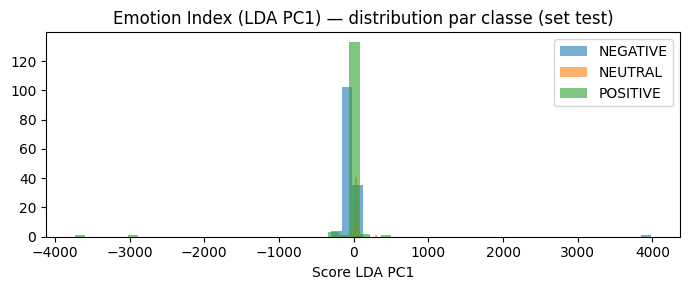

In [ ]:
# On calcule les "scores" LDA sur l’ensemble
scores_tr = best.named_steps['clf'].transform(best.named_steps['scaler'].transform(Xtr))
scores_te = best.named_steps['clf'].transform(best.named_steps['scaler'].transform(Xte))

# On prend PC1 comme indice 1D
idx = 0
plt.figure(figsize=(7,3))
for k,lab in enumerate(df['label'].cat.categories):
    plt.hist(scores_te[yte==k, idx], bins=30, alpha=0.6, label=lab)
plt.title("Emotion Index (LDA PC1) — distribution par classe (set test)")
plt.xlabel("Score LDA PC1"); plt.legend(); plt.tight_layout(); plt.show()


# Conclusion

PCA (var expliquée ≈ 36.8% + 9.6%) : on voit une structure, mais les classes se chevauchent -> signal émotionnel présent, pas massif.

Matrice de confusion :

NEUTRAL est le plus facile (rappel 0.90).

POSITIVE = NEGATIVE , se confondent davantage ( EEG émotion).

Histogramme du score LDA (PC1) : coeur des valeurs proche de 0 avec rares outliers -> probable lignes extrêmes dans les features (mauvais scaling ou valeurs aberrantes).